A collection of python tools for astronomical image analysis. <br>
By Geferson Lucatelli

Objectives:
1. Characterize the radio emission of radio maps.
2. Disentangle the radio subcomponents on these structures, e.g. compact components, diffuse emission
3. Break down the total flux contribution coming from the diffuse emission in relation to compact emission

Methods: Using multi-resolution radio images, we perform a multi-scale Sersic decomposition of the radio emission. 

Basically, this notebook contains:

    1. Plotting capabilities
    2. Signal processing / Image analysis (non-parametric)
    3. A fast and semi-automated image fitting decomposition implementation using the Sersic Law. 
    4. Others

Multiple libraries, functions, etc, are placed in the library file `libs/libs.py`. The module `morphen.py` helps to deal with different kinds of tasks. You can run it on a notebook or as a `CLI`. 



#### ISSUES: 
#### ***Using version 1.1.0 (`pip install lmfit==1.1.0`) is a MUST!!!.***
Please, do not use LMFIT version above 1.1.0. 

Actual reasons: Unknown

Possible reason: the communication of LMFIT (and SciPy) with JaX capabilities for LMFIT > 1.1.0 is not working as intended. We require a deeper investigation of what is causing this.

What is the effect? Minimisation gets stuck at boundaries!

Index:

1. [Introduction/Imports](#imports) <br>
2. [Data Manipulation](#data_manipulation) <br>
    2.1 [Preparing Images](#preparing_images) <br>
3. [Source Extraction](#source_extraction) <br>
4. [Multi-Sersic Fitting](#multi_sersic_fitting) <br>

<a id='imports'></a>

Currently, all python functions are located in the file `libs/libs.py`. 

In [1]:
import sys
import morphen as mp
# sys.path.append('libs/')
import libs as mlibs
import numpy as np
# from libs import *


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
   Radio Morphen              |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

## 1 - Reading Imaging Data

A set of example images can be found in this link: 

https://filedn.com/lNSVniBJI40jEXAJtSnTjPQ/astrodata/LIRGI_sample/data_examples/data_examples.tar.xz
<br>
With this, you can experiment with the usage of these tools. 


The default option of the following functions is to receive the image file as actually the filename, not the data it contains. 

Why? Because radio astronomy requires constantly reading/keeping information from the image header. 
<!-- In some functions, you can provide as input a 2D numpy array using the `data_2D` argument, but in that case you MUST provide the file name from which the data comes from.  -->

In [2]:
root_path_vla = 'data_examples/vla_only/VV705_C/' #only JVLA images.
root_path_eM = 'data_examples/emerlin_only/VV705_C/' #only e-MERLIN images.
root_path_comb = 'data_examples/combined/VV705_C/' #combined (e-MERLIN + JVLA) images.
prefix_images = 'MFS_images/north/*MFS-image.cutout_north.fits' #The north component of VV705

In [3]:
imagelist_vla = mlibs.glob.glob(root_path_vla+prefix_images)
imagelist_comb = mlibs.glob.glob(root_path_comb+prefix_images)
imagelist_eM = mlibs.glob.glob(root_path_eM+prefix_images)

In [4]:
#this function is helpfull to sort the image list according to the restoring 
# beam size (from smaller beams to larger beams). 
imagelist_vla,residuallist_vla = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_vla,return_df = False)
imagelist_eM,residuallist_eM = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_eM,return_df = False)
imagelist_comb,residuallist_comb = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_comb,return_df = False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 116.29it/s]


0 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
1 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
2 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
3 >> clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.80it/s]


0 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..-0.5-MFS-image.cutout_north.fits
1 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
2 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
3 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
4 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 148.98it/s]

0 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-1.0-MFS-image.cutout_north.fits
1 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.6-MFS-image.cutout_north.fits
2 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.4-MFS-image.cutout_north.fits
3 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.2-MFS-image.cutout_north.fits
4 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
5 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
6 >> clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits


In [5]:
imagelist_comb

array(['data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-1.0-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.6-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.4-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..-0.2-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits',
       'data_examples/combined/VV705_C/MFS_images/north/clean_image_VV705_combined_w_0.5_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits',


In [6]:
residuallist_vla

array(['data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-residual.cutout_north.fits',
       'data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-residual.cutout_north.fits',
       'data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-residual.cutout_north.fits',
       'data_examples/vla_only/VV705_C/MFS_residuals/north/clean_image__SDSSJ1518+4244.calibrated_avg_8s_newshift_RR_LL_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-residual.cutout_north.fits'],
      dtype=object)

In [7]:
imagelist_eM,residuallist_eM = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist_eM,return_df = False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 154.53it/s]

0 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..-0.5-MFS-image.cutout_north.fits
1 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-image.cutout_north.fits
2 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-image.cutout_north.fits
3 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-image.cutout_north.fits
4 >> clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits


In [8]:
residuallist_eM

array(['data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..-0.5-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.0-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..0.5-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..1.0-MFS-residual.cutout_north.fits',
       'data_examples/emerlin_only/VV705_C/MFS_residuals/north/clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-residual.cutout_north.fits'],
      dtype=object)

# 2 - Source Extraction

Before we head to the Sersic fitting, we must understand the structure of the radio emission. 
For that, we can perform a simple source extraction to the image and compute basic prior information, which includes:

1. Finding relevant regions of emission, and applying deblending where required. We get their locations `(x0,y0)`.
2. Computing first order sizes and effective intensities of these regions, for example $R_{50}$, $I_{50}$ and $R_p$.
3. 

We use this to construct a physically constrained Sersic model. The class `source_extraction` allow us to find relevant regions of emission. Only after that, one should proceed to the Sersic fitting. 

Let's load our data again, if required.

In [9]:
# lets select another image from our list of images. 
idx = -1
input_data=mp.read_data(filename=imagelist_eM[idx],
                        residualname=residuallist_eM[idx])

Image File: clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits
Residual File: clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-residual.cutout_north.fits


In [10]:
image_data = input_data.image_data_2D
residual_data = input_data.residual_data_2D

  >> Center -->  [512 510   0   0]


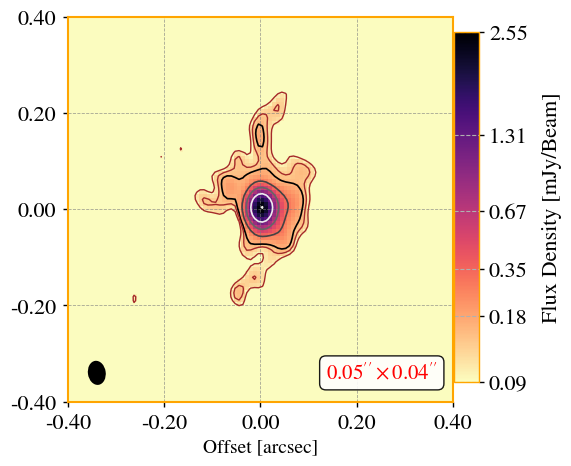

In [11]:
ax=mlibs.eimshow(input_data.filename,add_beam=True,crop=True,box_size=50,
        vmin_factor=3.0,vmax_factor=0.99, #level factor (max from peak, and min from std)
        neg_levels=np.asarray([-3]), # negative contours to draw -- which negative std level?
        CM='magma_r',
       )

Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


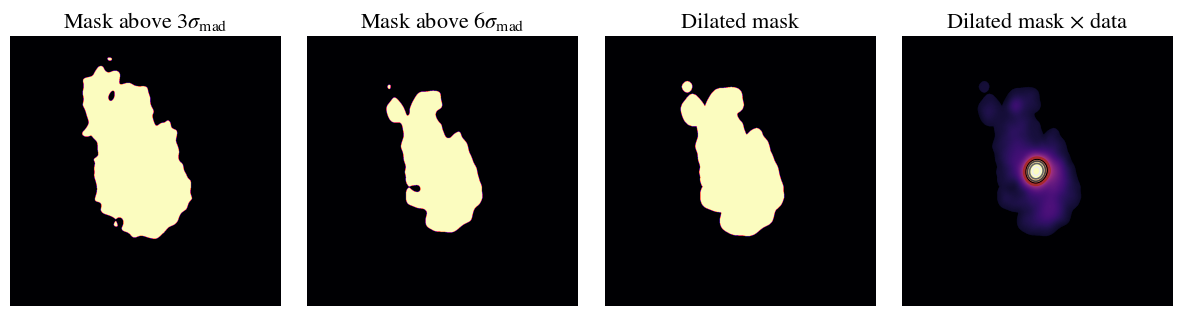

Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


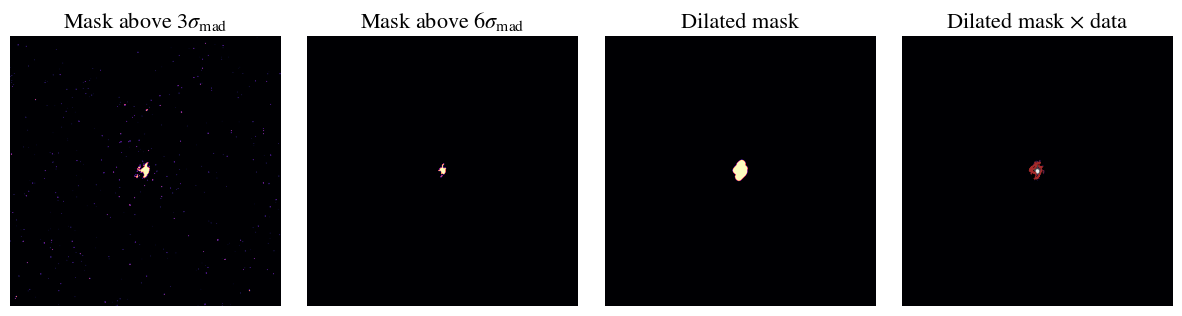

In [12]:
std = mlibs.mad_std(mlibs.ctn(imagelist_vla[2]))
_, mask = mlibs.mask_dilation(mlibs.ctn(imagelist_vla[2]), PLOT=True,dilation_type='disk',
                        sigma=6, iterations=2, dilation_size=None)
_, mask_self = mlibs.mask_dilation(mlibs.ctn(input_data.filename), PLOT=True,dilation_type='disk',
                        sigma=6, iterations=2, dilation_size=None)


In [13]:
def get_ell_size_factor(psf_current, psf_large=50, ell_large=2.0, psf_small=4, ell_small=7):
    """
    Rough linear relation between the restoring beam size (psf) with the scale factor of the ellipse to 
    be drawn on the detection map.
    """
    return ell_large + (ell_small - ell_large) * ((psf_current - psf_large) / (psf_small - psf_large))

### 3.1 Testing the Source-Extraction



Parameters that are critical for the source detection are the `SEP` arguments for the source extraction `bwf`, `bhf`, `fwf` and `fhf`. 

Currently, we are also implementing a Photutils algorithm (within PetroFit) for source detection, but more testing is required. We also plan to include AstroDendro and PyBDSF capabilities for this task.

WARNING: This is implementation is in an early stage, so it is not completely automated. It is required that the user interacts with it in order to check if the source detection is feasible. 



In [14]:
bwf, bhf = 2, 2
fwf, fhf = 8, 8
clean_param = 0.5
deblend_cont = 1e-6
deblend_nthresh = 5
sigma = 5
# ell_size_factor = 2.5
ell_size_factor = 1.0*get_ell_size_factor(psf_current = mlibs.get_beam_size_px(input_data.filename)[0])

In [15]:
mp.source_extraction??


Init signature:
mp.source_extraction(
    input_data,
    z=0.05,
    ids_to_add=[1, 2],
    crop=False,
    box_size=256,
    apply_mask=False,
    mask=None,
    dilation_size=None,
    sigma_level=3,
    sigma_mask=6,
    vmin_factor=3,
    mask_component=None,
    bwf=2,
    bhf=2,
    fwf=10,
    fhf=10,
    segmentation_map=True,
    filter_type='matched',
    deblend_nthresh=3,
    deblend_cont=1e-08,
    clean_param=0.5,
    clean=True,
    minarea_factor=1.0,
    sort_by='flux',
    sigma=12,
    ell_size_factor=2.0,
    show_detection=False,
    show_petro_plots=False,
    SAVE=True,
    show_figure=True,
    dry_run=False,
)
Source:        
class source_extraction():
    """
    Source extraction class, responsible to find relevant regions of emission.

    For now, only SEP is implemented. Soon, other algorithms will be added
    in this class as alternatives for source extraction. These are:
        - PyBDSF
        - AstroDendro
        - Photutils
    """
    def __init_

To check if the source detection is good, you may pass the argument `dry_run=True` which will only display the regions detected, without performing any calculations. 

So, lets run a `dry_run` source detection. This will only show the detected sources, without returning any prior properties. 

This is useful in case you do not know for sure the noise structure of the image. Suppose that the number of structures detected are many (false detections, due to poor SNR). That will take some time to compute their properties. 

5.393645922749118
Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
object 0: flux = 0.049948 +/- 5.307537


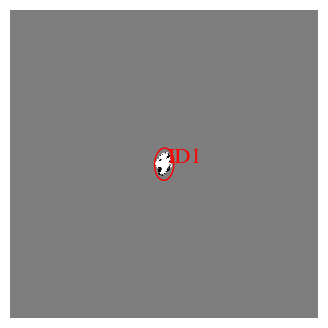

In [16]:

SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=1.0,
                          apply_mask=True,sigma_mask=6,
                          show_petro_plots=True,
                          dry_run=True)
# plt.imshow(input_data.image_data_2D)

In [17]:
SE.objects['xc'],SE.objects['yc']

(array([512]), array([510]))

### 3.2 Decomposition of the Radio Emission
Another point to consider relates to the source structure. 

### ** The question we ask is **: 
Is a single model component enough to model each detected individual structure? 

In the example above, is one model component (for structure `ID1`) enough to model the source emission? Let's look at the data again:

  >> Center -->  [512 510   0   0]


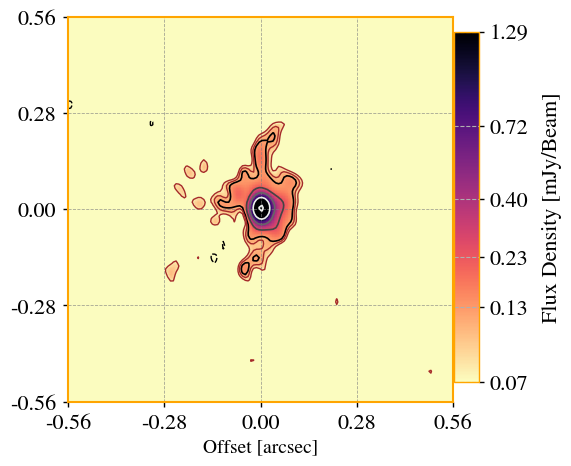

In [18]:
ax=mlibs.eimshow(input_data.filename,crop=True,box_size=70)

### ** The answer is: probably not! ** 

So, what we can do is to specify to which source ID we may add an extra model component. 
The default is to attribute to each `ID` a model component `COMP`, for example, `ID_1` > `COMP_1`, `ID_2` > `COMP_2`, etc. 
But in our case, `ID1` is a complicated structure, and we require an extra model component, i.e. `COMP_2`.

The `source_extraction` class, the argument used for this is `ids_to_add`, which is a list. In our case, to add another model component to `ID1`, we use `ids_to_add = [1]`. So, our source `ID1` will be decomposed into `COMP_1` and `COMP_2`. 
Note that at the current stage of `morphen`, this is a manual step. 

By default, the object containing the source structure information begins with a source `ID` and its associated model component `COMP_`. It is the interaction of the user that will link additional model components to each source structure. 


If you are happy with the source detection, have decided how many components (`COMP_`s) do you need, and have attributed the components to corresponding source `ID`s, you may proceed. Remember to set `dry_run = False`.

5.393645922749118
Not able to determine cell size. Please, provide a cell size with the parameter `cell_size`.
object 0: flux = 0.049948 +/- 5.307537


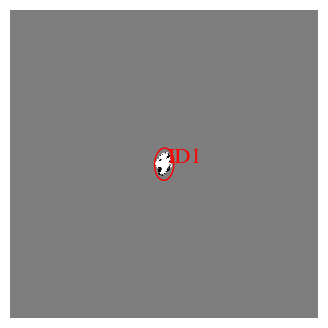

1


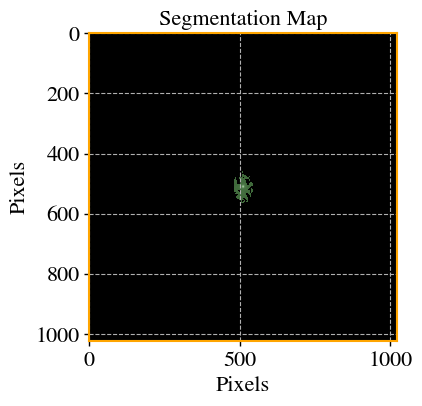

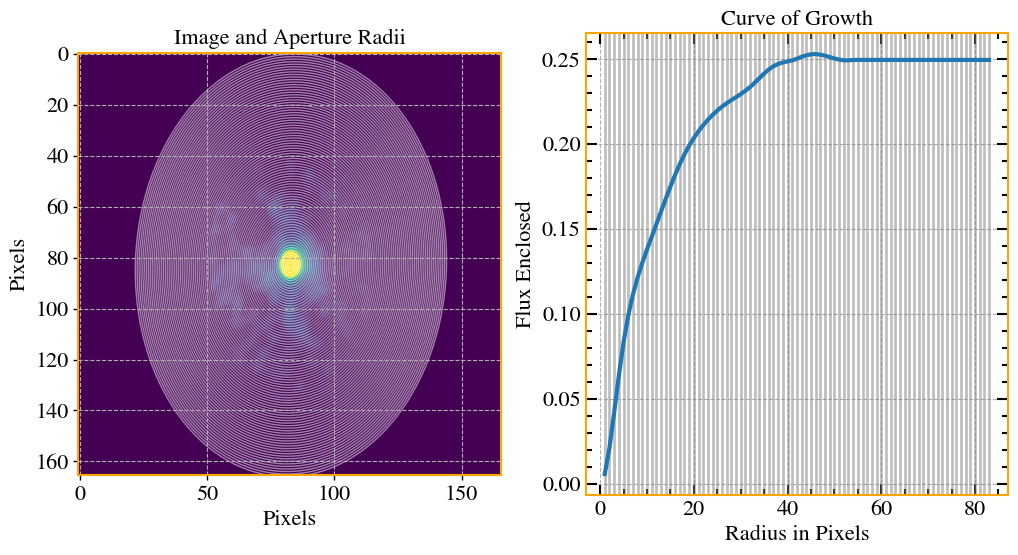

/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/libs.py:2010: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


PSF SIZE is 1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-10-10 02:25:04	WARN	componentlist::close	componentlist closed


# of components to be fitted = 1
# of model components to be fitted = 2


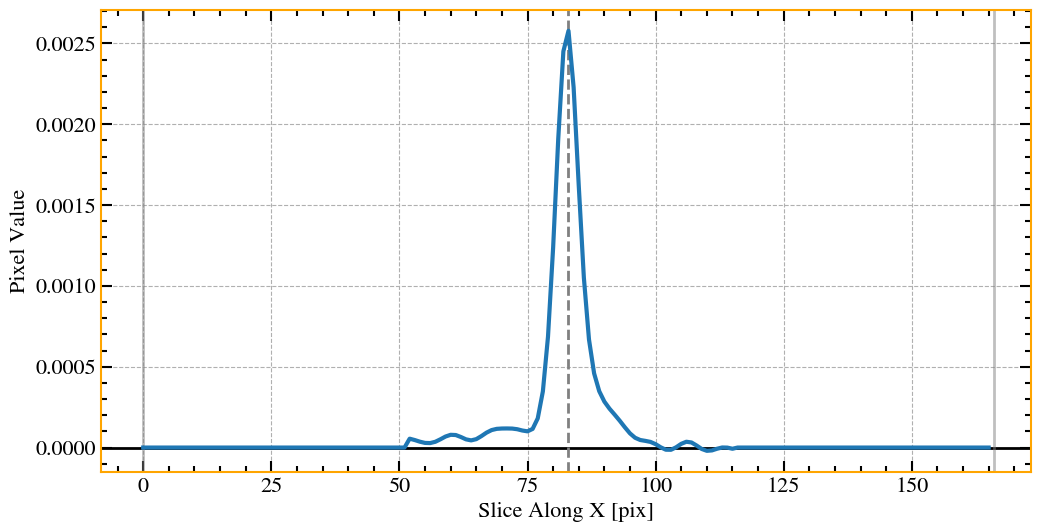

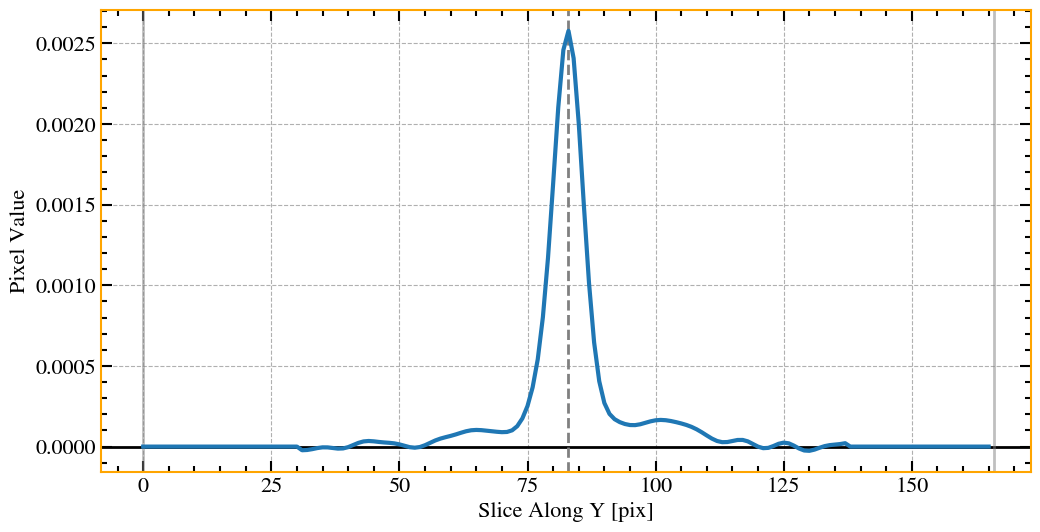

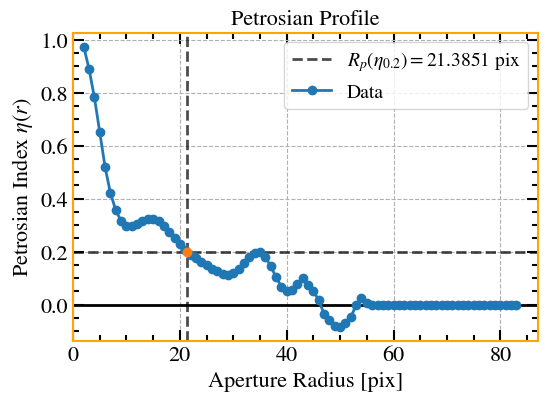

In [19]:
SE = mp.source_extraction(input_data, ids_to_add=[1],
                          ell_size_factor = ell_size_factor, sigma=sigma,
                          bwf=bwf, bhf=bhf, fwf=fwf, fhf=fhf,
                          clean_param=clean_param, 
                          deblend_cont=deblend_cont, 
                          deblend_nthresh=deblend_nthresh,
                          apply_mask=True,sigma_mask=10,
                          show_petro_plots=True,
                          dry_run=False)

By default, components that are added to a source ID, contains a copy of the properties from the parent ID with some exceptions. In our example, we have `ID_1 -> (COMP_1, COMP_2)`, where: 
- the positions of `COMP_1`, `(x0,y0)` are copied onto `COMP_2`.
- the starting constraint of the effective radii of `COMP_2` is 3 times of that of `COMP_1`.
- the starting constraint of the effective intensity of `COMP_2` is 0.1 times of that of `COMP_1`.

More information can be found in the function responsible to generate a new model component from a parent one. 

In [20]:
mlibs.add_extra_component??

Signature: mlibs.add_extra_component(petro_properties, copy_from_id)
Source:   
def add_extra_component(petro_properties, copy_from_id):
    """
    Create another component from a dictionary (petro_properties) having
    photometric properties for N detected components in an image.

    Params
    ------
    petro_properties: dict
        Contain parameters of a number o N components obtained
        by a petrosian analysis of all detected sources.
        Example (these are actually the keys() from the dictionary):
        ['c1_PA', 'c1_q', 'c1_area', 'c1_Re',
        'c1_x0c', 'c1_y0c', 'c1_label', 'c1_R50',
        'c1_Snu', 'c1_Rp', 'c1_Rpidx', 'c1_rlast',
        'c1_I50']
    copy_from: int
        From which component copy parameters from.
        This is useful, for example, the source has two components detected,
        1 compact and the other a structure that can not be modelled by a single
        sersic function. Then, we need one function to model the compact structure,


We can check the dictionary containing such photometric properties:


In [21]:
SE.sources_photometries

{'c1_PA': -87.64580671559992,
 'c1_q': 0.7357264589597967,
 'c1_area': 3522.0,
 'c1_Re': 33.48264355064144,
 'c1_x0c': 510.7486253430508,
 'c1_y0c': 512.4532700580063,
 'c1_label': 1,
 'c1_R50': 8.611122224444888,
 'c1_R20': 3.3948789757951587,
 'c1_R80': 19.863772754550908,
 'c1_C1': 0.7672374414535502,
 'c1_Snu': 0.2511153987487031,
 'c1_Rp': 21.38507701540308,
 'c1_Rpidx': 42,
 'c1_rlast': 83,
 'c1_I50': 0.00017761935643128318,
 'ncomps': 2,
 'c2_PA': -87.64580671559992,
 'c2_q': 0.7357264589597967,
 'c2_area': 3522.0,
 'c2_Re': 33.48264355064144,
 'c2_x0c': 510.7486253430508,
 'c2_y0c': 512.4532700580063,
 'c2_label': 1,
 'c2_R50': 25.833366673334663,
 'c2_R20': 3.3948789757951587,
 'c2_R80': 19.863772754550908,
 'c2_C1': 0.7672374414535502,
 'c2_Snu': 0.2511153987487031,
 'c2_Rp': 21.38507701540308,
 'c2_Rpidx': 42,
 'c2_rlast': 83,
 'c2_I50': 1.7761935643128318e-05}

# Sersic Multi-Fit
Now, we are ready to proceed for to the fitting part. 

We can use the source extraction object `SE` to feed it into the multi-sersic fitting. 

By default, the code fixes all Sersic indeces to `n=0.5` for all model components. It also fixes all components to its detected positions `(x0,y0)` during the source extraction step, but gives an interval of +/-10 px during the optimisation. 

You can modify this by passing the arguments `dr_fix = [3,50]`, meaning that `COMP_1` is very spatially constrained, and can vary only +/- 3 pixels, while `COMP_2` is spatially constrained to a larger bound, the algorithm will search in the boundary of +/- 50 pixels during optimisation.

Another important observation is that, since we want to decompose the radio structure in terms of compact and diffuse emission, we must specify which model components corresponds to compact structures and diffuse structures. 

In our case, `COMP_1` (always the brightest part of the source, an assumption that holds for compact structures) is our compact model, and `COMP_2` will be our diffuse model. Do not worry about the diffuse labels, just focus on the compact labels. We pass this information via the argument `comp_ids`. The algorithm will determine automatically the labels for diffuse structures (in our case, will be `2`). If your model has a single model component (e.g. in the previous step, you have used `ids_to_add = []`), diffuse structures will be considered to be the residual. 

A comprehensive example using 5 model components is provided at the end of this notebook.


#######################
['2'] ['1' '2']
Fitting clean_image_1518+4244_avg8s_4096_0.008arcsec_10000.briggs.-multiscale..2.0-MFS-image.cutout_north.fits
rms res =  0.9969088591188711
rms data =  17.54974547763469 ; rms res =  17.495496741935366 ; ratio =  0.9969088591188711
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


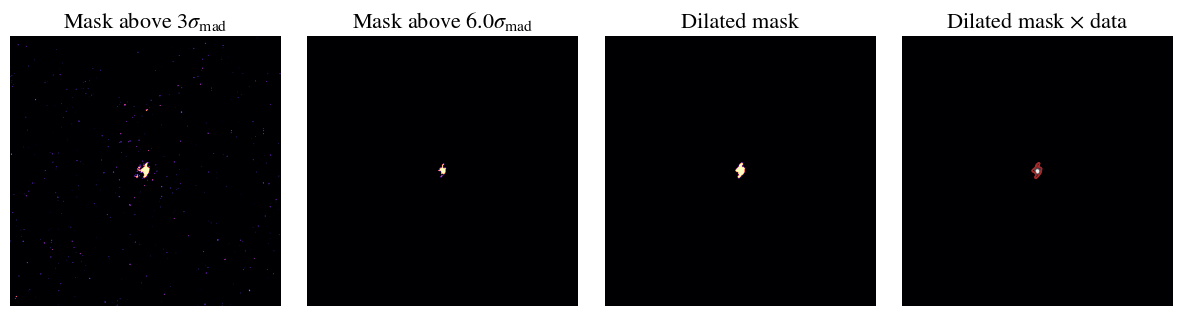

PSF BEAM SIZE is >=>  5
PSF SIZE is >=>  1024
INFO: Using Elliptical Gaussian for Gaussian beam convolution.


2023-10-10 02:25:27	WARN	componentlist::close	componentlist closed
2023-10-10 03:25:26.799128: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:458] TfrtCpuClient created.
2023-10-10 03:25:27.044206: I external/xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:910] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-10 03:25:27.045067: I external/xla/xla/service/service.cc:168] XLA service 0x564d191f62c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 03:25:27.045096: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-10-10 03:25:27.046244: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:627] Using BFC allocator.
2023-10-10 03:25:27.046363: I external/xla/xla/pjrt/gpu/gp

Limiting  x0
Limiting  y0
Fixing Sersic Index of component 0  to 0.5.
Limiting  x0
Limiting  y0
Fixing Sersic Index of component 1  to 0.5.
{'f1_x0': {'value': 510.7486253430508, 'min': 505.7486253430508, 'max': 515.7486253430508}, 'f1_y0': {'value': 512.4532700580063, 'min': 507.4532700580063, 'max': 517.4532700580063}, 'f1_PA': {'value': -87.64580671559992, 'min': -177.64580671559992, 'max': 2.3541932844000826}, 'f1_ell': {'value': 0.2642735410402033, 'min': 0.05285470820804066, 'max': 0.5285470820804066}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.00017761935643128318, 'min': 1.7761935643128318e-05, 'max': 0.017761935643128317}, 'f1_Rn': {'value': 8.611122224444888, 'min': 0.08611122224444888, 'max': 17.222244448889775}, 'f1_cg': {'value': 0.0, 'min': -0.01, 'max': 0.01}, 'f2_x0': {'value': 510.7486253430508, 'min': 460.7486253430508, 'max': 560.7486253430508}, 'f2_y0': {'value': 512.4532700580063, 'min': 462.4532700580063, 'max': 562.4532700580063}, 'f2_

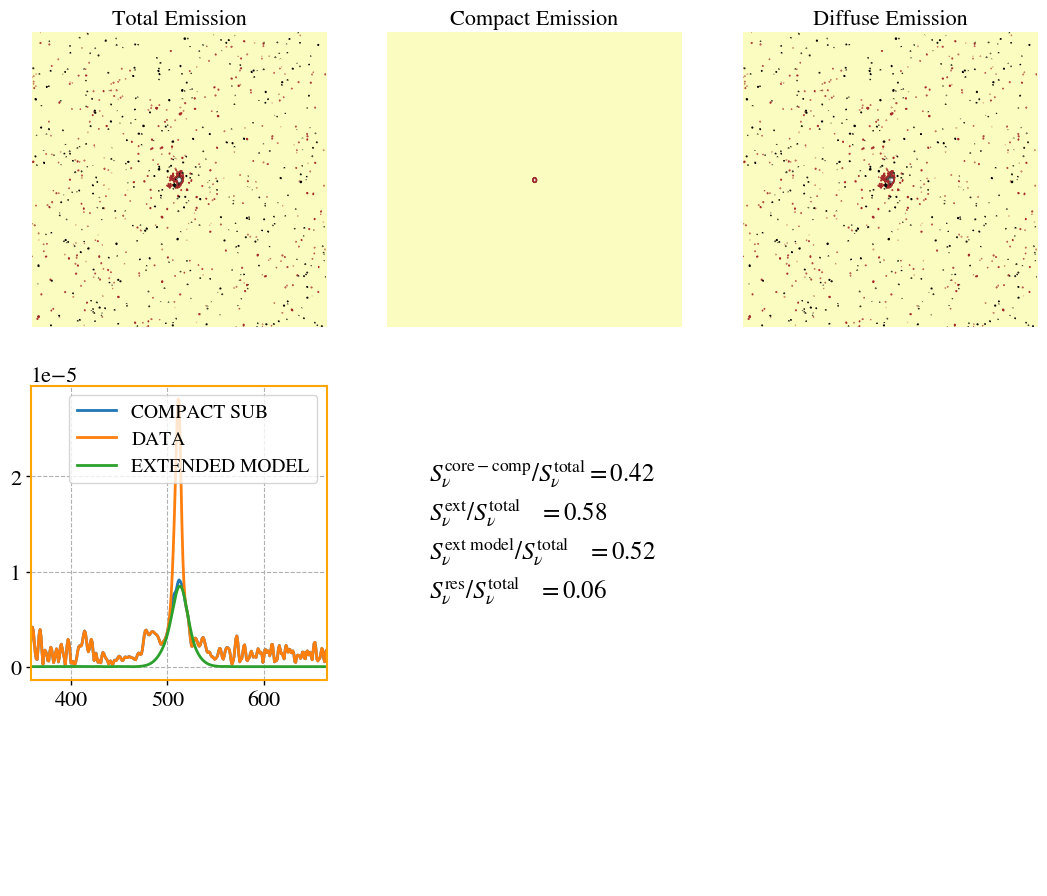

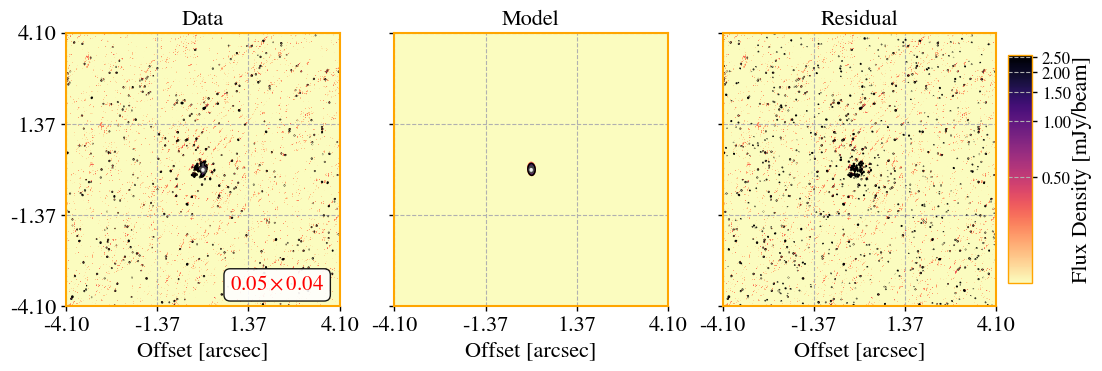

/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/libs.py:2010: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


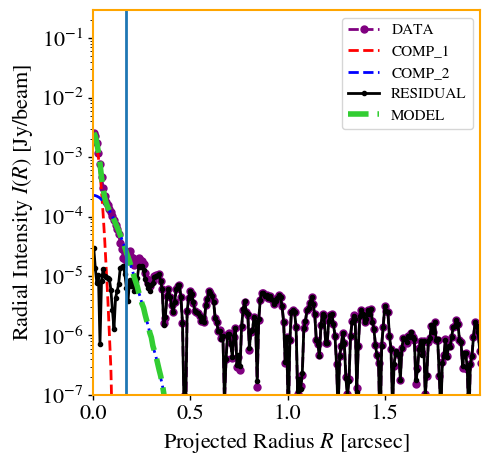

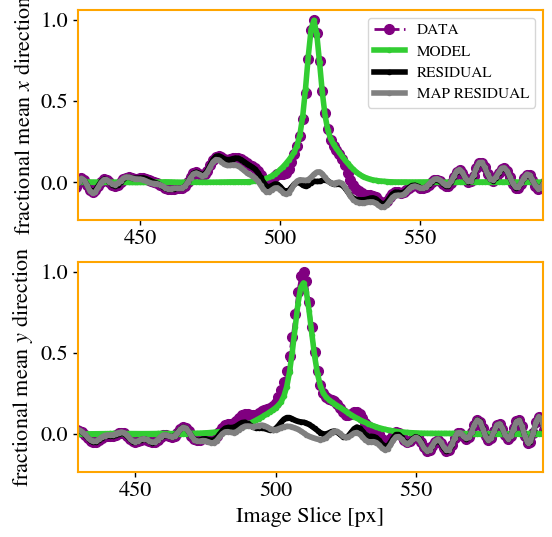

Using rms provided...
128 512 384


/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


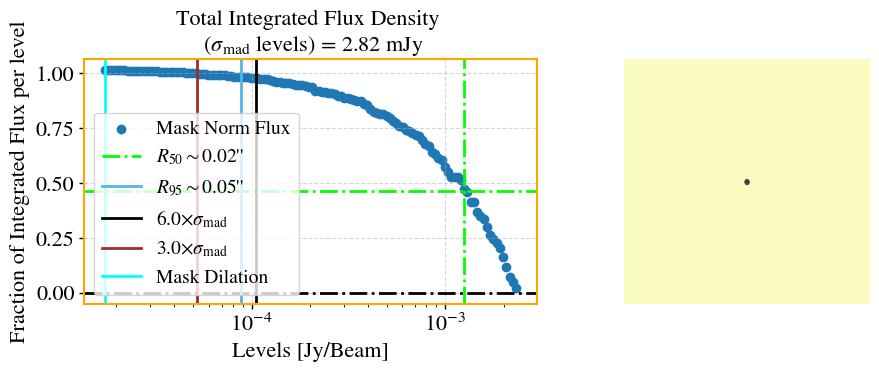

/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/libs.py:2010: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


Using rms provided...
128 512 384
non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse


/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


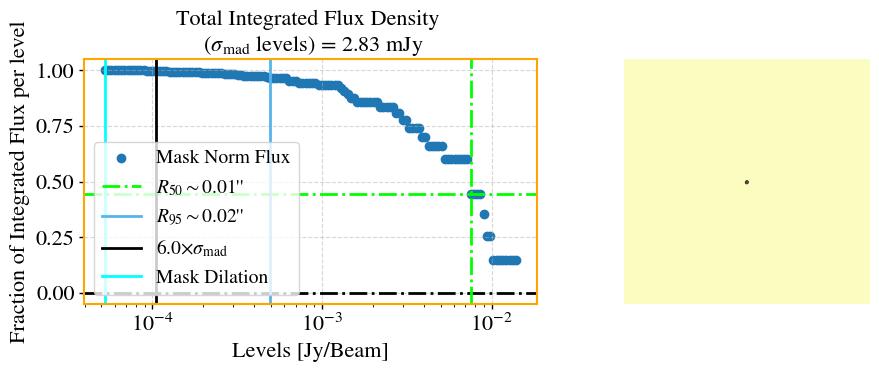

/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/libs.py:2010: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


Using rms provided...
128 512 384


/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


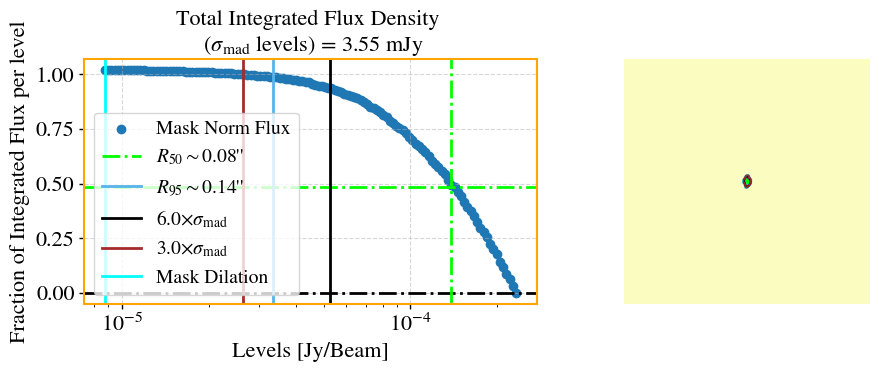

/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/libs.py:2010: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


Using rms provided...
128 512 384


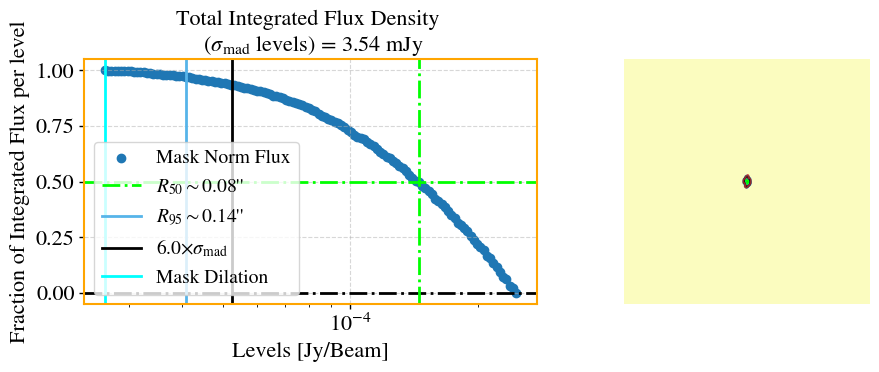

/media/sagauga/xfs_evo/cloud/pcloud-arch/PhD/GitHub/morphen/libs/libs.py:2010: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
2023-10-10 03:26:13 - INFO - +--------------------------------+
2023-10-10 03:26:13 - INFO - | Core-Compact Component Sizes |
2023-10-10 03:26:13 - INFO - +--------------------------------+
2023-10-10 03:26:13 - INFO -  >=> Beam Size = 5.00 px
2023-10-10 03:26:13 - INFO -  >=> Beam Size = 32.82  pc
2023-10-10 03:26:13 - INFO -  >=> Rn Main Compact = 8.92  pc
2023-10-10 03:26:13 - INFO -  >=> C50 Compact Deconv Radii = 7.41  pc
2023-10-10 03:26:13 - INFO -  >=> C50 Compact Conv Radii = 18.52  pc
2023-10-10 03:26:13 - INFO -  >=> C95 Compact Deconv Radii = 17.37  pc
2023-10-10 03:26:13 - INFO -  >=> C95 Compact Conv Radii = 42.39  pc
2023-10-10 03:26:13 - INFO - +----------------------------+
2023-10-10 03:26:13 - INFO - | Extended Component Sizes |
2023-10-10 03:26:13 - INFO - +--

In [22]:
smfr = mp.sersic_multifit_radio(input_data,
                                SE, #source extraction object, from previous step
                                which_residual = 'shuffled', #natural or shuffled (natural is experimental!)
                                fix_geometry=True, #for stability purposes, keep True for now. 
                                comp_ids=['1'],# which component ID is compact?
                                dr_fix=[5,50,5,100,100,100],#for each component, radial element size to fix (x0,y0) positions
                                fix_value_n=[0.5,0.5,0.5,0.5,0.5,0.5,0.5],#for each component, the Sersic index value to be fixed. 
                                fix_n=[True,True,True,True,True,True],#for each component, fix or not the Sersic index. 
                                aspect=None,#elliptical or circular gaussian for beam convolution? 
                                z = mlibs.z_d['VV705'])

### Analysing Results


All results are stored in the object `smfr`. 
Model images (convolved and deconvolved) are saved as `.fits` files having a copy of the header 
from the original image file data. Example of these files are: 
 - `*_dec_model.fits` >> Deconvolved total model.
 - `*_model.fits` >> Convolved total model.
 - `*_residual.fits` >> Residual model image. 
 - `*_dec_model_component_i.fits` >> Deconvolved model image for model component `i`. `i` vary from 1 to the total number of model components.
 - `*_model_component_i.fits` >> Convolved model image for model component `i`.
 - `*_compact.fits` >> Convolved image containing all compact structures.
 - `*_extended.fits` >> Convolved image containing the extended structures. This is obtained by `extended = data - compact`.
 - `*_fit.pickle` >> Contains a pickle object with all the `LMFIT` results.
 - `*_fit_modeldict.pickle` >> Contains a pickle object with all model components images (convolved and deconvolved). Note, this is a big file.
 - `*_model_mini_params.csv` >> contain the best-fit minimised parameters and (when possible) standard errors.
 - `*_mini_corr.csv` >> When successful, this contains the correlation matrix for the model parameters. 


First, we can inspect the model images, residual and diffuse emission.

## The structure of the diffuse emission
Lets visualise the model images of our fitting. 

  >> Center -->  [512 510   0   0]


Text(0.5, 1.0, 'Data')

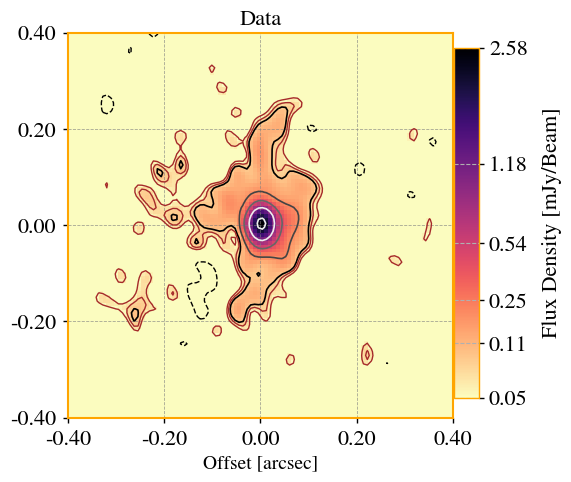

In [33]:
# center = nd.maximum_position(input_data.image_data_2D)
center = (int(smfr.results_fit['f1_x0'][0]),int(smfr.results_fit['f1_y0'][0]))
rms = input_data.rms_res
ax = mlibs.eimshow(input_data.filename,
             crop=True,box_size=50,vmax_factor=1.0,
             vmax=input_data.image_data_2D.max(),rms=rms)
ax.set_title('Data')

Error loading fits file
Error loading fits file
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Diffuse Emission')

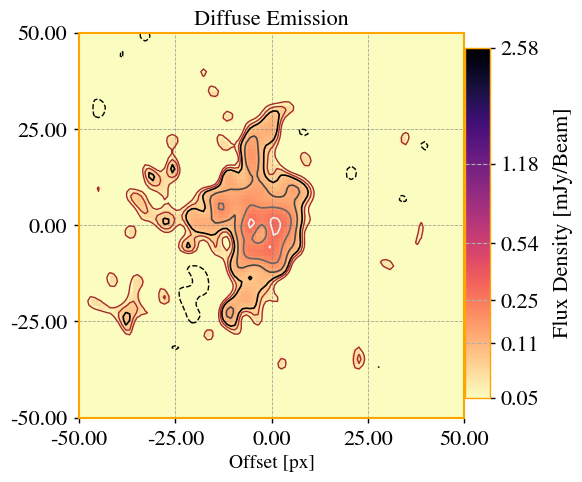

In [58]:
ax = eimshow(input_data.image_data_2D- smfr.models[0]['model_c1_conv'],
        crop=True,box_size=50,vmax_factor=1.0,
        rms=rms,vmax=input_data.image_data_2D.max())
ax.set_title('Diffuse Emission')

Error loading fits file
Error loading fits file
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Compact Deconvolved')

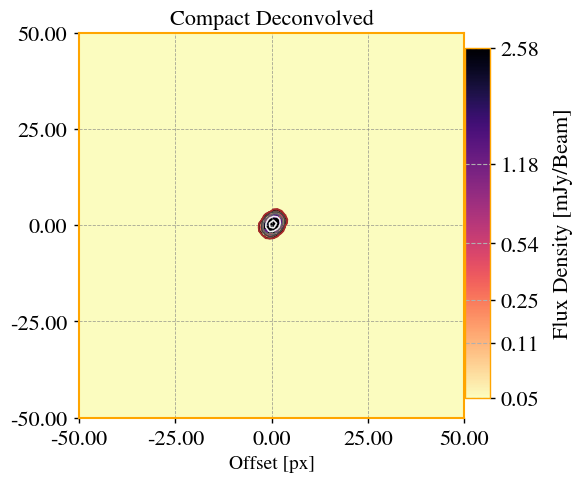

In [59]:
ax=eimshow(smfr.models[0]['model_c1'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Deconvolved')

Error loading fits file
Error loading fits file
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Compact Convolved')

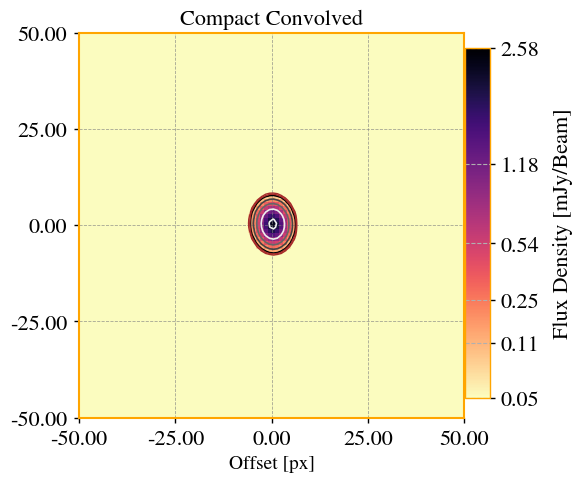

In [60]:
ax=eimshow(smfr.models[0]['model_c1_conv'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Convolved')

Error loading fits file
Error loading fits file
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Model Deconvolved')

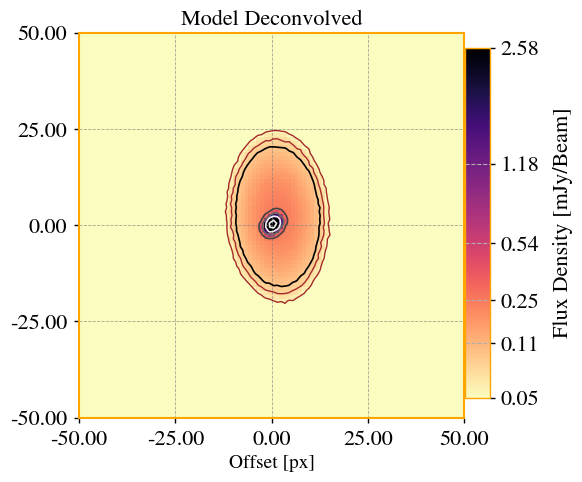

In [61]:
ax=eimshow(smfr.models[0]['model_total'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Deconvolved')

Error loading fits file
Error loading fits file
No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Model Convolved')

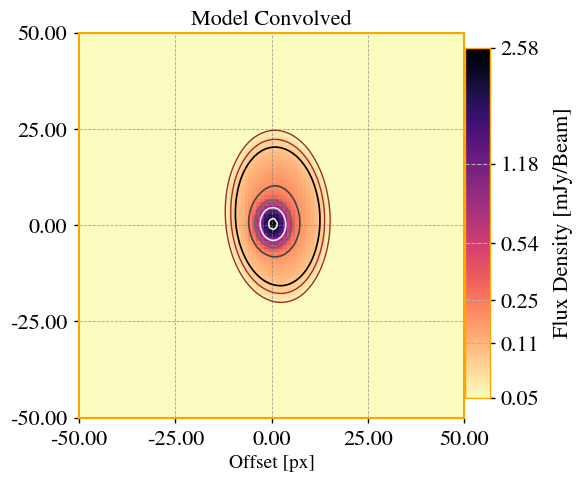

In [62]:
ax=eimshow(smfr.models[0]['model_total_conv'],
           crop=True,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Convolved')

No cell or pixel size information in the image wcs/header. Setting cell/pixel size = 1.


Text(0.5, 1.0, 'Residual')

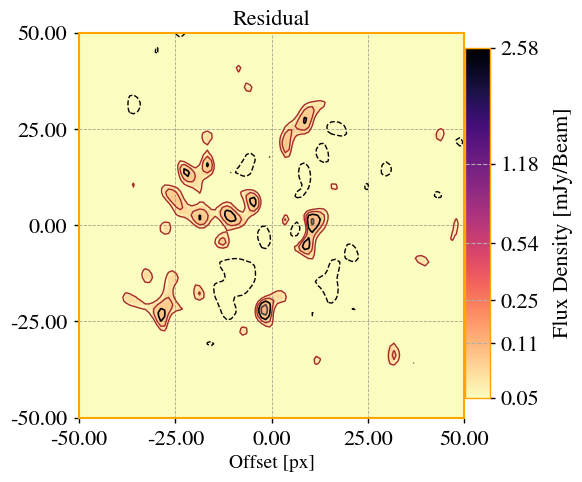

In [63]:
ax = eimshow(input_data.image_data_2D- smfr.models[0]['model_total_conv'],
             center=center,
             crop=True,box_size=50,vmax_factor=1.0,vmin_factor=3,
             rms=rms,
             vmax=input_data.image_data_2D.max()
            )
ax.set_title('Residual')

In [64]:
print(f"Total flux in model = {smfr.results_fit['flux_density_model'][0]:.2f} mJy")
print(f"Total flux in data = {smfr.results_fit['flux_data'][0]:.2f} mJy")
print(f"Total flux in res = {smfr.results_fit['flux_res'][0]:.2f} mJy")


Total flux in model = 6.39 mJy
Total flux in data = 6.84 mJy
Total flux in res = 0.44 mJy


#### Analysing fit statistics (model parameters)

In [65]:
smfr.lmfit_results[0]

name,value,standard error,relative error,initial value,min,max,vary
f1_x0,510.595982,0.00620469,(0.00%),510.5959818709099,505.748625,515.748625,True
f1_y0,508.539598,0.00770167,(0.00%),508.5395982201611,507.453270,517.453270,True
f1_PA,-129.722157,2.61202436,(2.01%),-129.72215717362369,-177.645807,2.35419328,True
f1_ell,0.24003034,0.01743999,(7.27%),0.24003034443827378,0.05285471,0.52854708,True
f1_n,0.50999993,0.34298872,(67.25%),0.5099999334961163,0.49000000,0.51000000,True
f1_In,0.00717839,0.00444696,(61.95%),0.007178389940741699,1.7762e-05,0.01776194,True
f1_Rn,1.36106368,0.72335435,(53.15%),1.361063678118219,0.08611122,17.2222444,True
f1_cg,-0.01000000,1.20924740,(12092.47%),-0.009999999975871771,-0.01000000,0.01000000,True
f2_x0,511.817315,0.05110791,(0.01%),511.817314970396,460.748625,560.748625,True
f2_y0,510.535821,0.08391557,(0.02%),510.53582086067024,462.453270,562.453270,True


### Check decomposition results: Compact vs Extended
Now, we can investigate the integrated fluxes between core-compact structures in relation to diffuse ones. 

Note that we consider that the diffuse flux density is the sum between the flux density from the extended model component and the flux density of the residual map.

In [117]:
print(f"Total flux in compact = {smfr.results_fit['flux_density_compact'][0]:.2f} mJy")
print(f"Total flux in extended = {smfr.results_fit['flux_density_extended_model'][0] + smfr.results_fit['flux_res'][0]:.2f} mJy")

# The total flux density in the diffuse regions are saved in:
print(f"Total flux in extended = {smfr.results_fit['flux_density_ext2'][0]:.2f} mJy")


Total flux in compact = 6.76 mJy
Total flux in extended = 5.76 mJy
Total flux in extended = 5.75 mJy


### Physical Sizes of the components
For completeness, we calculate convolved and deconvolved physical properties. 
The properties of the deconvolved model images, referent to compact structures, are stored inside `smfr.results_compact_deconv_morpho`, while properties of convolved model images for compact structures in `smfr.results_compact_conv_morpho`. 

Similarly, we have for the extended structures: `smfr.results_ext_deconv_morpho` and `smfr.results_ext_conv_morpho`. 

Each one of these measurements stores the same quantities that were calculated with `radio_image_analysis` previously, for the full radio emission, but now for individual model components. 

In [118]:
# list(smfr.results_compact_conv_morpho.keys())

In [119]:
# Lets calculate the pixel size in physical units (pc).
print(f"Redshift of VV705 = {z_d['VV705']}")
pix_to_pc = pixsize_to_pc(z=z_d['VV705'],
                          cell_size=get_cell_size(input_data.filename))
print(f"1 px = {pix_to_pc:.2f} pc")

Redshift of VV705 = 0.04019
1 px = 6.56 pc


#### Compact Components
First, let's analyse the results for our compact model(s)/structure(s).

In [120]:
# The effective radius in terms of the Sersic Rn parameter.
# This is a deconvolved quantity.
print(f"Rn ={smfr.results_fit['f1_Rn'][0] * pix_to_pc : .0f} pc")

Rn = 76 pc


In [121]:
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R50 ={smfr.results_compact_deconv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Deconv R50 = 73 pc


In [122]:
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R50 ={smfr.results_compact_conv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Conv R50 = 175 pc


##### Total sizes

In [123]:
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R95 ={smfr.results_compact_deconv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Deconv R95 = 180 pc


In [124]:
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R95 ={smfr.results_compact_conv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Conv R95 = 421 pc


#### Extended Components
Now, we move to our diffuse model(s)/structure(s).

In [125]:
print(f"Rn ={smfr.results_fit['f5_Rn'][0] * pix_to_pc : .0f} pc")

Rn = 1341 pc


In [126]:
print(f"Deconv R50 ={smfr.results_ext_deconv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Deconv R50 = 559 pc


In [127]:
print(f"Conv R50 ={smfr.results_ext_conv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")

Conv R50 = 616 pc


#### Total Sizes

In [128]:
print(f"Deconv R95 ={smfr.results_ext_deconv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Deconv R95 = 1601 pc


In [129]:
print(f"Conv R95 ={smfr.results_ext_conv_morpho['C95radii'][0] * pix_to_pc : .0f} pc")

Conv R95 = 1631 pc


### Compute SFR Estimates for Diffuse Structures and the Brightness Temperature
For star formation rates, some assumptions are made, as discussed in the paper. 

Here, we take just an approximation, since we are using only one frequency. 
But we are interested in the amount of energy that is coming from diffuse structures, and try to translate that to SFR.

We use the fitting results to compute the SFR. Within `smfr`, information is stored regarding the total flux density in the extended structures (`'flux_density_ext2'`) and the sizes.

The class `radio_star_formation` from `morphen` deals with the calculations, provided the object `smfr`. Note also that you need to provide the redshift of the galaxy. 

In [130]:
SFR = mp.radio_star_formation(input_data,smfr,z=z_d['VV705'])

2023-10-05 12:10:32 - INFO - Using frequency of 6.00 GHz for star formation estimate.
2023-10-05 12:10:32 - INFO - +-----------------+
2023-10-05 12:10:32 - INFO - | SFR Estimates |
2023-10-05 12:10:32 - INFO - +-----------------+
2023-10-05 12:10:32 - INFO -  ==> SFR =44.64 +/- 0.25 Mo/yr
2023-10-05 12:10:32 - INFO - +------------------+
2023-10-05 12:10:32 - INFO - | sSFR Estimates |
2023-10-05 12:10:32 - INFO - +------------------+
2023-10-05 12:10:32 - INFO -  >=> Deconvolved A50 sSFR = 45.39 Mo/(yr kpc^2)
2023-10-05 12:10:32 - INFO -  >=> Convolved A50 sSFR = 37.43 Mo/(yr kpc^2)
2023-10-05 12:10:32 - INFO -  >=> Deconvolved A95 sSFR = 5.54 Mo/(yr kpc^2)
2023-10-05 12:10:32 - INFO -  >=> Convolved A95 sSFR = 5.34 Mo/(yr kpc^2)
2023-10-05 12:10:32 - INFO - +--------------------------+
2023-10-05 12:10:32 - INFO - | Brightness Temperature |
2023-10-05 12:10:32 - INFO - +--------------------------+
2023-10-05 12:10:32 - INFO -  ==> TB Rn Fit = 0.11 e5 K
2023-10-05 12:10:32 - INFO -  =

In [100]:
mp.radio_star_formation??

Init signature:
mp.radio_star_formation(
    input_data,
    SMFR,
    decompose=True,
    z=0.01,
    calibration_kind='Murphy12',
    alpha=-0.85,
    alpha_NT=-0.85,
    frequency=None,
)
Source:        
class radio_star_formation():
    """
    Compute star-formation estimates from radio emission, given the converstion
    law.
    """

    def __init__(self, input_data, SMFR,decompose = True,z=0.01,
                 calibration_kind='Murphy12',
                 alpha = -0.85, alpha_NT = -0.85, frequency = None):
        self.input_data = input_data
        self.SMFR = SMFR
        self.decompose = decompose
        self.z = z
        self.frequency = frequency #in GHz
        self.alpha = alpha
        self.alpha_NT = alpha_NT
        self.return_with_error = True
        self.cell_size = mlibs.get_cell_size(self.input_data.filename)
        self.pix_to_pc = mlibs.pixsize_to_pc(z=self.z,
                                  cell_size=self.cell_size)


        if frequency is None:
  

In [101]:
SFR = mp.radio_star_formation(input_data,smfr,z=z_d['VV705'],calibration_kind='Murphy12',frequency=6)

2023-10-05 02:37:56 - INFO - +-----------------+
2023-10-05 02:37:56 - INFO - | SFR Estimates |
2023-10-05 02:37:56 - INFO - +-----------------+
2023-10-05 02:37:56 - INFO -  ==> SFR =38.25 +/- 0.65 Mo/yr
2023-10-05 02:37:56 - INFO - +------------------+
2023-10-05 02:37:56 - INFO - | sSFR Estimates |
2023-10-05 02:37:56 - INFO - +------------------+
2023-10-05 02:37:56 - INFO -  >=> Deconvolved A50 sSFR = 28.18 Mo/(yr kpc^2)
2023-10-05 02:37:56 - INFO -  >=> Convolved A50 sSFR = 25.63 Mo/(yr kpc^2)
2023-10-05 02:37:56 - INFO -  >=> Deconvolved A95 sSFR = 4.45 Mo/(yr kpc^2)
2023-10-05 02:37:56 - INFO -  >=> Convolved A95 sSFR = 4.38 Mo/(yr kpc^2)
2023-10-05 02:37:56 - INFO - +--------------------------+
2023-10-05 02:37:56 - INFO - | Brightness Temperature |
2023-10-05 02:37:56 - INFO - +--------------------------+
2023-10-05 02:37:56 - INFO -  ==> TB Rn Fit = 0.10 e5 K
2023-10-05 02:37:56 - INFO -  ==> TB R50 Fit = 1.31 e5 K
